In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [12]:
torch.manual_seed(42)
np.random.seed(42)
num_samples = 100
input_dim = 10
output_dim = 1

X = torch.sin(torch.randn(num_samples, input_dim))
noise = torch.randn(num_samples, output_dim) * 0.1
weights_true = torch.randn(input_dim, output_dim)
y = torch.matmul(X, weights_true) + noise

In [13]:
hidden_width = min(input_dim, output_dim)

class LinearNN(nn.Module):
    def __init__(self, num_hidden_layers, std,
                 input_dim=input_dim, hidden_width=hidden_width, output_dim=output_dim):
        super(LinearNN, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, hidden_width, bias=False))
        for l in range(num_hidden_layers-1): # Depth
            self.model.add_module(f"linear{l}", nn.Linear(hidden_width, hidden_width, bias=False))
        self.model.add_module("output", nn.Linear(hidden_width, output_dim, bias=False))
        self._initialize_weights_uniform(std)

    def forward(self, x):
        return self.model(x)

    def _initialize_weights_uniform(self, std):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.uniform_(module.weight, a=-std, b=std)

In [14]:
lr = 0.01
num_iterations = 500
distances = [[0 for i in range(num_iterations)] for k in range(2)]
traj_norms = [[0 for i in range(num_iterations)] for k in range(2)]
nn_norms = [[0 for i in range(num_iterations)] for k in range(2)]
def frac_pow(matrix, power): # Matrix is assumed to be diagonalizable 
        eigenvalues, eigenvectors = torch.linalg.eigh(matrix)
        eigenvalues = torch.round(eigenvalues, decimals=5) # Rounding to avoid numerical stability issues
        fractional_eigenvalues = eigenvalues.pow(power)
        fractional_diag_matrix = torch.diag(fractional_eigenvalues)
        fractional_matrix = eigenvectors @ fractional_diag_matrix @ eigenvectors.t()
        return fractional_matrix
torch.manual_seed(42)
for k, num_hidden_layers in enumerate(range(1, 3)):
    N = num_hidden_layers + 1
    model = LinearNN(num_hidden_layers, 0.5)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    def vectorize(): # Returns vectorized parameters in the current state
        return torch.cat([p.detach().view(-1) for p in model.parameters()])
    
    def e2e_matrix(w_inputs): # Computes the e2e matrix of the given parameters
        start_idx = 0 # Start index of current parameters
        w = None
        for k, p in enumerate(model.parameters()):
            end_idx = start_idx + p.detach().view(-1).shape[0] # End index of current parameters
            if k == 0:
                w = w_inputs[start_idx:end_idx].view(p.shape).t()
            else:
                w = w.mm(w_inputs[start_idx:end_idx].view(p.shape).t())
            start_idx = end_idx # Advance start index
        return w
    
    def e2e_grad(e2e):
        return 2 * X.t() @ (X @ e2e - y) / num_samples
    
    w_traj_old = e2e_matrix(vectorize())
    for i in range(num_iterations):
        # Compute loss
        predictions = model(X)
        loss = criterion(y, predictions)

        # Backprop. step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        w_nn = e2e_matrix(vectorize())
        
        grad = e2e_grad(w_traj_old)
        w_traj_new = w_traj_old
        for j in range(1, N+1):
            w_traj_new = torch.sub(w_traj_new, lr * frac_pow(torch.mm(w_traj_old, w_traj_old.t()), (j-1)/N) @ \
                                grad @ \
                                frac_pow(torch.mm(w_traj_old.t(), w_traj_old), (N-j)/N))
        w_traj_old = w_traj_new
        distances[k][i] = torch.norm(torch.sub(w_nn,w_traj_new))
        traj_norms[k][i] = torch.norm(w_traj_new)
        nn_norms[k][i] = torch.norm(w_nn)
        

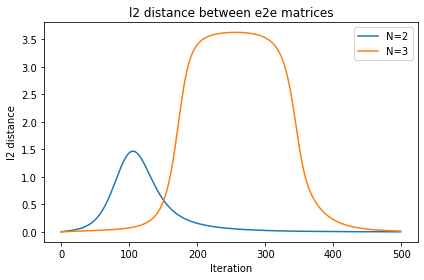

In [15]:
# Plotting the results
plt.figure()

for k, num_hidden_layers in enumerate(range(1, 3)):
    plt.subplot(1, 1, 1)
    plt.plot(range(0, num_iterations), distances[k], label=f'N={num_hidden_layers+1}')
    plt.xlabel('Iteration')
    plt.ylabel('l2 distance')
    plt.title('l2 distance between e2e matrices')
    plt.legend()

plt.tight_layout()
plt.show()

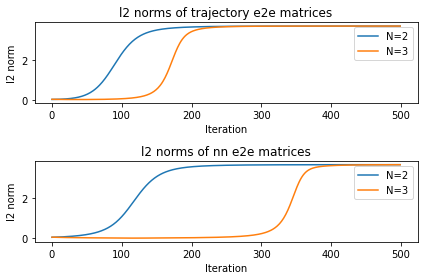

In [16]:
# Plotting the results
plt.figure()

for k, num_hidden_layers in enumerate(range(1, 3)):
    plt.subplot(2, 1, 1)
    plt.plot(range(0, num_iterations), traj_norms[k], label=f'N={num_hidden_layers+1}')
    plt.xlabel('Iteration')
    plt.ylabel('l2 norm')
    plt.title('l2 norms of trajectory e2e matrices')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(0, num_iterations), nn_norms[k], label=f'N={num_hidden_layers+1}')
    plt.xlabel('Iteration')
    plt.ylabel('l2 norm')
    plt.title('l2 norms of nn e2e matrices')
    plt.legend()

plt.tight_layout()
plt.show()